In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image

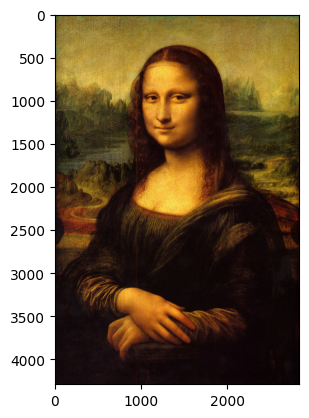

In [2]:
cont_img = Image.open('TEST4/contido.jpg').convert('RGB')
plt.imshow(cont_img)

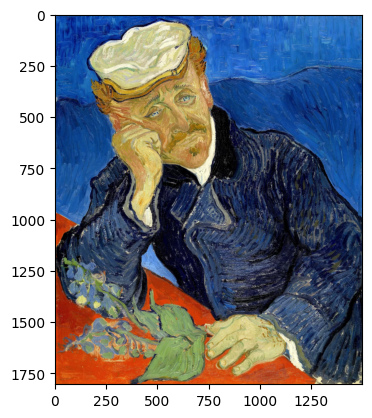

In [3]:
style_img = Image.open('TEST4/estilo.jpg').convert('RGB')
plt.imshow(style_img)

In [4]:
cont_img.size

(2835, 4289)

In [5]:
style_img.size

(1500, 1804)

In [6]:
rgb_mean = torch.Tensor([0.485, 0.456, 0.406])
rgb_std = torch.Tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [7]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

C:\Proxectos\NST\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Proxectos\NST\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
print(pretrained_net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
style_layers, cont_layers = [0, 5, 10, 19, 28], [21]

In [10]:
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(cont_layers+style_layers)+1)])

In [11]:
def extract_features(X, cont_layers, style_layers):
    conts = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in cont_layers:
            conts.append(X)
    return conts, styles

In [12]:
def get_conts(image_shape, device):
    cont_X = preprocess(cont_img, image_shape).to(device)
    cont_Y, _ = extract_features(cont_X, cont_layers, style_layers)
    return cont_X, cont_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, style_Y = extract_features(style_X, cont_layers, style_layers)
    return style_X, style_Y


In [13]:
def cont_loss(Y_hat, Y):
    return torch.square(Y_hat-Y.detach()).mean()

def gram(X):
    n_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((n_channels, n))
    return torch.matmul(X, X.T) / (n_channels * n)
    
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())


In [14]:
cont_weight, style_weight, tv_weight = 1.0, [1, 0.75, 0.2, 0.2, 0.2], 10.0
beta = 1e6

def compute_loss(X, conts_Y_hat, styles_Y_hat, conts_Y, styles_Y_gram):
    conts_l = [cont_loss(Y_hat, Y) * cont_weight for Y_hat, Y in zip(conts_Y_hat, conts_Y)]
    styles_l = [style_loss(Y_hat, gram_Y) * style_weight[i] * beta for i, [Y_hat, gram_Y] in enumerate(zip(styles_Y_hat, styles_Y_gram))]
    tv_l = tv_loss(X) * tv_weight
    l = sum(styles_l + conts_l + [tv_l])
    return conts_l, styles_l, tv_l,  l

In [15]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))
    def forward(self):
        return self.weight

In [16]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [17]:
generated_images = []  
error_content_list = []
error_style_list = []
error_tv_list = []

In [18]:
def train(X, conts_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.85)
    for epoch in range(num_epochs):
        trainer.zero_grad()
        conts_Y_hat, styles_Y_hat = extract_features(X, cont_layers, style_layers)
        conts_l, style_l, tv_l, l = compute_loss(X, conts_Y_hat, styles_Y_hat, conts_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        error_content_list.append(conts_l[0].item())  
        error_style_list.append(style_l[0].item())  
        error_tv_list.append(tv_l.item())
        if (epoch+1) % 20 == 0 or epoch == 0:
            generated_images.append(postprocess(X.clone())) 
    return X 

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_shape = [(400, 600), (500, 400)]
net = net.to(device)
cont_X, cont_Y = get_conts(image_shape[1], device)
_ , style_Y = get_styles(image_shape[1], device)
output = train(cont_X, cont_Y, style_Y, device, 0.3, 1000, 100)

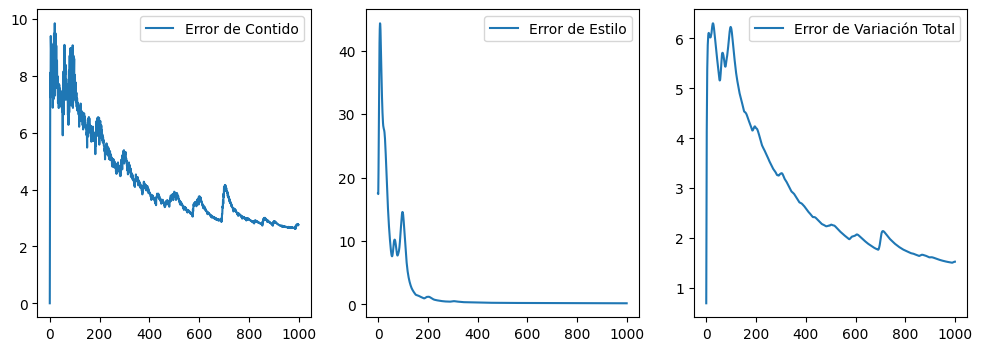

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(error_content_list[:], label='Error de Contido')
plt.legend()
plt.subplot(132)
plt.plot(error_style_list[:], label='Error de Estilo')
plt.legend()
plt.subplot(133)
plt.plot(error_tv_list, label='Error de Variación Total')
plt.legend()
plt.show()

In [21]:
for i, img in enumerate(generated_images):
    if i == 0: 
        img.save('TEST4\generated_image_1.png')
    else:
        img.save(f'TEST4\generated_image_{i*20}.png')

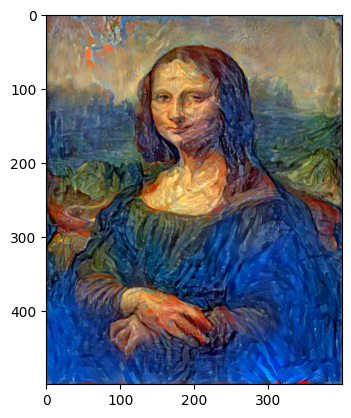

In [24]:
plt.imshow(generated_images[-1])